## Assignment 3: Adversarial attacks and defenses
**Course:** Security and Interpretability of Machine Learning algorithms <br>
**Student:** Danis Alukaev <br>
**Email:** d.alukaev@innopolis.university <br>
**Group:** B19-DS-01 

### Abstract

This notebook contains implementation of Kernel Density Estimation defense and its evaluation on zero-knowledge, perfect-knowledge, and limited-knowledge attacks. For all experiments I have used methodolgy described in ["Adversarial Examples Are Not Easily Detected: Bypassing Ten Detection Methods"](https://arxiv.org/abs/1705.07263) by Carlini N. and Wagner D. Although I managed to replicate the claimed results, the defense has shown a better performance on local set-up (perhaps because of stochasticity of experiments and different hyper-parameters).

### 0. Prerequisites.

In [1]:
import torch 
import torchvision
import os
import pickle
import matplotlib
import albumentations as A
import random
import numpy as np
import random
import gc

In [2]:
from albumentations import pytorch
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import balanced_accuracy_score
from abc import ABC, abstractmethod
from sklearn.metrics import ConfusionMatrixDisplay
from time import time
from tqdm import tqdm
from math import log
from scipy.stats import skew, ttest_ind

In [3]:
configs = {
    "num_workers": 4,
    "device": "cuda:0",
    "batch_size": 128,
    "epochs": 50
}

In [4]:
import warnings
warnings.filterwarnings("ignore")

### 1. Loading data 

The CIFAR-10 dataset was downloaded from [official publisher](https://www.cs.toronto.edu/~kriz/cifar.html) and mounted to `data/cifar/` directory. Further, the loading of data will be performed through Dataset abstraction. Native implementation does not support transforms via Albumentations package, so I create a custom class for this purpose.

In [5]:
class AlbumentationsCIFAR10(CIFAR10):
    """
    Custom CIFAR10 dataset applying transformations according to
    Albumentations standard. Inherited from native PyTorch dataset
    implementing the retrival logic.
    """
    def __init__(self, root, train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)
    
    def __getitem__(self, idx):
        image, label = self.data[idx], self.targets[idx]
        if self.transform is None:
            return image, label
        try:
            transformed = self.transform(image=image)['image']
        except Exception as e:
            print(e)
            transformed = self.transform(image)
        return transformed, label
            

There will be two types of transforms: train and test. Both include the normalization and converting to Tensors. Still, the former one also applies random augmentations to increase the robustness of the model. For instance, there are horizontal flip, scale rotations, elastic transforms. By construction, augmentations will be applied on each epoch, so that the model will be trained on previously unseen samples.

In [6]:
train_augmentations = A.Compose([
    # A.augmentations.transforms.Normalize(),
    A.HorizontalFlip(p=0.5),
    A.augmentations.geometric.transforms.ShiftScaleRotate(p=0.5),
    A.augmentations.geometric.transforms.ElasticTransform(p=0.1),
    pytorch.transforms.ToTensorV2(),
])

test_augmentations = A.Compose([
    # A.augmentations.transforms.Normalize(),
    pytorch.transforms.ToTensorV2(),
])

Further in the notebook, there will be used validation, train, and test datasets. The validation set will be used to check the overall performance of the trained model. The train and test sets will be used for training the model.

In [7]:
trainset = AlbumentationsCIFAR10(root='data', train=True, download=True, transform=train_augmentations)
trainloader = DataLoader(trainset, batch_size=configs['batch_size'], shuffle=True, num_workers=configs['num_workers'])

Files already downloaded and verified


In [8]:
split_ration = 0.5

controlset = AlbumentationsCIFAR10(root='data', train=False, download=True, transform=test_augmentations)
test_size = int(split_ration * len(controlset))
validation_size = len(controlset) - test_size
testset, validationset = torch.utils.data.random_split(controlset, [test_size, validation_size], generator=torch.Generator().manual_seed(42))
testloader = DataLoader(testset, batch_size=configs['batch_size'], shuffle=False, num_workers=configs['num_workers'])
validationloader = DataLoader(validationset, batch_size=configs['batch_size'], shuffle=False, num_workers=configs['num_workers'])

Files already downloaded and verified


In [9]:
print(f"Datasets' sizes: train {len(trainset)}, test: {len(testset)}, validation: {len(validationset)}")

Datasets' sizes: train 50000, test: 5000, validation: 5000


Let's examine five random samples from training population. The images themselves are a litle bit messy, but still the depicted entity can be distinguished. Note that these are the images after transformations (different from the original).

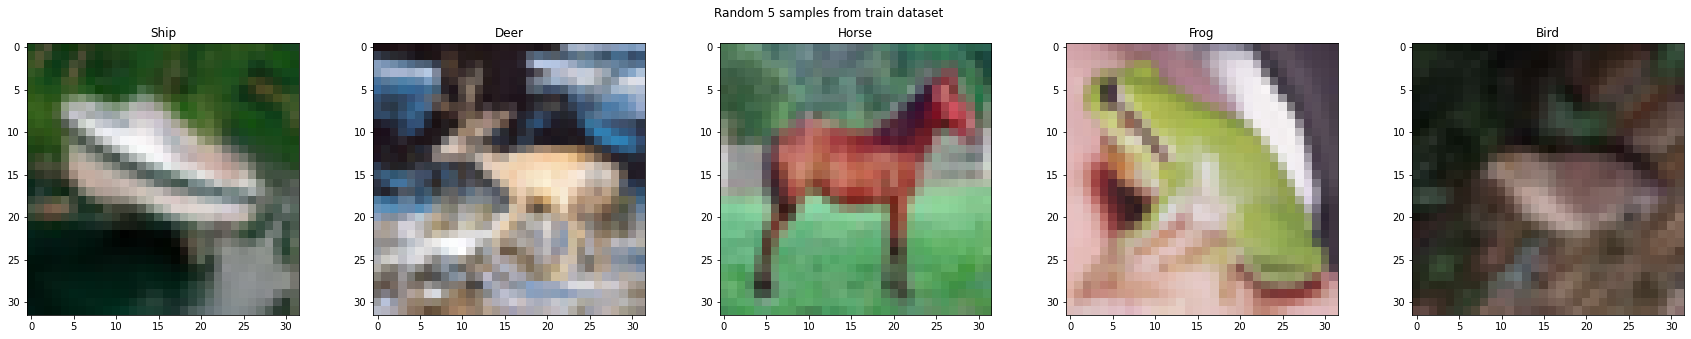

In [10]:
labels_text = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
classes = {i: labels_text[i] for i in range(len(labels_text))}

fig, axes = plt.subplots(1, 5)
fig.set_size_inches(30, 5)
fig.suptitle("Random 5 samples from train dataset")
for ax in axes:
    idx = random.randint(0, len(trainset)-1)
    image, label = trainset[idx]
    image = image / 255.0
    ax.set_title(f"{classes[label]}")
    image = np.clip(image.permute(1, 2, 0), 0, 1)
    ax.imshow(image)
plt.show()

### 2. Inference model

Multi-label classification of objects in images is known problem. Various state-of-art model were developed. For instance, the Residual Network (ResNet) significantly improved the performance of deep neural networks. The overall idea and architecture are presented in ["Deep Residual Learning for Image Recognition"](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming H. et al. For this assignment I will implement the variation of ResNet with 34 layers.

In [11]:
class ResidualBlock(nn.Module):
    """
    Building block for residual network. Implements an idea of skip connections 
    (a.k.a. shortcuts). Default configuration involves triple-layre skip. 
    """
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels 
        self.stride = stride
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = self.__make_shortcut()
        
    def __make_shortcut(self):
        if self.stride == 1 and self.expansion * self.out_channels == self.in_channels:
            return nn.Sequential()
        shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expansion * self.out_channels, kernel_size=1, stride=self.stride, bias=False),
            nn.BatchNorm2d(self.expansion * self.out_channels) 
        )
        return shortcut
    
    def forward(self, x):
        _x = x.clone() 
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += self.shortcut(_x)
        x = F.relu(x)
        return x

In [12]:
class ResNet(nn.Module):
    """
    Class implementing the Residual Network by Kaiming H. et al.
    Comprised of blocks with skip connections to preserve sensitive information 
    over the layers. By default, performs multi-label classification for 10 classes.
    """
    
    def __init__(self, in_channels, out_channels, blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.blocks = blocks
        self.num_classes = num_classes
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.layers = []
        channels = out_channels
        for idx, num_blocks in enumerate(blocks):
            stride = 1 if idx == 0 else 2
            layer = self.__make_layer(ResidualBlock, channels, num_blocks, stride)
            self.layers.append(layer)
            channels *= 2  
        self.layers = nn.ModuleList(self.layers)
        
        self.fc1 = nn.Linear(channels // 2 * ResidualBlock.expansion, num_classes) 
        self.latent_representation = None

    def __make_layer(self, Block, channels, num_blocks, first_stride):
        blocks = []
        for idx in range(num_blocks):
            stride = first_stride if idx == 0 else 1
            block = Block(self.out_channels, channels, stride)
            self.out_channels = channels * Block.expansion
            blocks.append(block)
        layer = nn.Sequential(*blocks)
        return layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        for layer in self.layers:
            x = layer(x)
        x = F.avg_pool2d(x, 4)
        x = x.view(x.size(0), -1)
        self.latent_representation = x
        y = self.fc1(x)
        return y

The best performance is shown on the epoch 50 (see Assignment 1), so these weights will be used for inference. Since the weights weigh a lot (~260 Mb), I uploaded them on [google drive](https://drive.google.com/file/d/1MT5XlZF4KdDLuNzEg3110voe4PFSB9dg/view?usp=sharing).

In [13]:
checkpoint = torch.load(os.path.join("weights", "baseline.pt"))
baseline = ResNet(3, 64, [3, 4, 6, 3]).to(configs['device'])
baseline.load_state_dict(checkpoint['model_state_dict'])
baseline.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): ModuleList(
    (0): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2

In [14]:
def validate(model, loader):
    """Evaluation routine for the model. 
    
    Iteratively retrieves new batch from dataloader, feeds it to the
    model, computes balanced accuracy score, and plots confustion matrix.
    
    Parameters
    ----------
    model : torch.Module
        model to be validated
    
    loader : torch.data.utils.Dataloader
        iterable with sample batches

    Returns
    -------
    accuracy : float
        average balanced accuracy score (in %) of a model
    """
    model.eval()
    history = {"True": [], "Predicted": []}
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(configs['device']), labels.to(configs['device'])
            predictions = model(images / 255.0)
            del images
            torch.cuda.empty_cache()
            
            _, predicted_classes = predictions.max(1)
            predicted_classes = predicted_classes.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            
            history["True"] += list(labels)
            history["Predicted"] += list(predicted_classes)
    
    accuracy = balanced_accuracy_score(history["True"], history["Predicted"])
    ConfusionMatrixDisplay.from_predictions(history["True"], history["Predicted"], display_labels=labels_text, xticks_rotation='vertical')
    plt.show()
    return accuracy

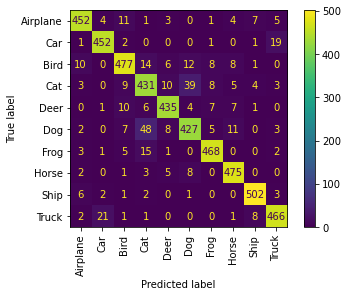

In [15]:
accuracy = validate(baseline, validationloader)

In [16]:
print(f"The baseline model has reached {accuracy * 100:.2f}% of weighted accuracy.")

The baseline model has reached 91.77% of weighted accuracy.


### 3. Adversarial attacking

This section presents implementaton of Carlini & Wagner (C&W) attack. The impact of this attack on a baseline model will be measured in terms of balanced accuracy score. The adversarial samples will be generated from validation set, on which the baseline scored 92% of balanced accuracy.

In [17]:
def visualize_single_attack(model, attack):
    """Visualize result of an attack on a model.

    Plots original image along with targeted and untargeted adversarial 
    sample. All auxiliary information is specified in suptitle of each
    image.

    Parameters
    ----------
    model : torch.Module
        model to be attacked
    
    attack : tuple
        pair of attack name and instance of attack class
    """
    model.cpu()
    name, f = attack
    idx = random.randint(0, len(validationset) - 1)
    image, label = validationset[idx]
    _image = image / 255.0
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(15, 5)
    fig.suptitle(f'{name} applied to sample with label "{classes[label]}"')

    pred_original = model(_image.unsqueeze(0))
    _, pred_original_class = pred_original.max(1)
    ax1.set_title(f'Original: pred="{classes[pred_original_class[0].item()]}"')
    ax1.imshow(np.clip(_image.permute(1, 2, 0), 0, 1))
    
    adversarial = f(model, _image.unsqueeze(0), torch.LongTensor([label]))
    pred_adversarial = model(adversarial)
    _, pred_adversarial_class = pred_adversarial.max(1)
    ax2.set_title(f'Adversarial no target: pred="{classes[pred_adversarial_class[0].item()]}"')
    ax2.imshow(np.clip(adversarial[0].permute(1, 2, 0).detach().numpy(), 0, 1))
    
    target_idx = label
    while target_idx == label:
        target_idx = random.randint(0, len(labels_text) - 1)
    target_class = classes[target_idx]
    adversarial = f(model, _image.unsqueeze(0), torch.LongTensor([label]), torch.LongTensor([target_idx]))
    pred_adversarial = model(adversarial)
    _, pred_adversarial_class = pred_adversarial.max(1)
    ax3.set_title(f'Adversarial target {target_class}: pred="{classes[pred_adversarial_class[0].item()]}"')
    ax3.imshow(np.clip(adversarial[0].permute(1, 2, 0).detach().numpy(), 0, 1))
    
    plt.show()

In [18]:
def validate_adversarial(model, loader, attack):
    """Check the performance of model on attacked validation dataset.

    Iteratively attacks model using new batch of validation dataset. Computes
    ba

    Iteratively retrieves new batch from dataloader, attacks the model using it, 
    feeds adversarial samples to model, computes balanced accuracy score on 
    adversarial samples, and plots confustion matrix.

    Parameters
    ----------
    model : torch.Module
        model to be validated
    
    loader : torch.data.utils.Dataloader
        iterable with sample batches
    
    attack : tuple
        pair of attack name and instance of attack class
    """
    name, f = attack
    model.to(configs['device'])
    model.eval()
    history = {"True": [], "Predicted": []}
    for i, (images, labels) in enumerate(loader):
        images, labels = images.to(configs['device']), labels.to(configs['device'])
        adversarial = f(model, images / 255.0, labels)
        predictions = model(adversarial)
        del images, adversarial
        torch.cuda.empty_cache()
        _, predicted_classes = predictions.max(1)
        predicted_classes = predicted_classes.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()

        history["True"] += list(labels)
        history["Predicted"] += list(predicted_classes)
    
    accuracy = balanced_accuracy_score(history["True"], history["Predicted"])
    print(f"Attack {name}: The baseline model has reached {accuracy * 100:.2f}% of weighted accuracy.")
    
    ConfusionMatrixDisplay.from_predictions(history["True"], history["Predicted"], display_labels=labels_text, xticks_rotation='vertical')
    plt.show()

#### 3.1. Carlini & Wagner (C&W)

This approach was proposed by Carlini and Wagner in ["Towards Evaluating the Robustness of Neural Networks"](https://arxiv.org/abs/1608.04644). The attack there is formulated as a minimization of $\mathcal{D}(x, x+\delta) + c \cdot f(x + \delta)$ such that $x + \delta \in [0, 1]^n$, where $\mathcal{D}$ is a distance metric (e.g. $l_2$ norm), and $f$ is an objective function. Authors suggest to use $f(x') = \max (\max_{i \neq t} (F(x')_i)-F(x')_t, 0)$ that correspond to $f_6$ in paper. The constant $c$ is a topic for further study, but from Fig.2 it seems that the value of $1.5$ is sufficient. To ensure that the output image is valid, the box constraint is defined through change the variables trick as $\delta_i=\frac{1}{2}(\tanh(w_i)+1)-x_i$.

In [19]:
class CarliniWagnerAttack:
    """
    Implementation of Carlini & Wagner attack.
    """
    
    def __init__(self, c=10, lr=1e-2, iterations=10, device="cuda"):
        """Constructor of Carlini & Wagner attack.

        Parameters
        ----------
        c : int
            coefficient on which loss function f6 is multiplied
        
        lr : float
            learning rate of an attack
        
        iterations : int
            number of iterations of an attack
        
        device : str
            device to use for computations
        """
        self.c = c
        self.lr = lr
        self.iterations = iterations
        self.device = device
    
    def __call__(self, model, x, y, target=None):
        """Attack the model.

        Parameters
        ----------
        model : torch.Module

        x : torch.Tensor
            images of an input batch

        y : torch.Tensor
            class labels of an input batch

        target : torch.Tensor
            target class labels for the attack
        
        Returns
        -------
        adversarial_sample : torch.Tensor
            resultant adversarial sample
        """
        adversarial_sample = self._attack(model, x, y, target)
        return adversarial_sample

    def _attack(self, model, x, y, target):
        """Implementation of attacking.

        Adversarial sample is the result of optimization with an objective 
        function comprised of L2-norm and rectifier function f6 as suggested 
        in original paper. Note that resultant adversarial sample is in the 
        range of [0..1].

        Parameters
        ----------
        model : torch.Module

        x : torch.Tensor
            images of an input batch

        y : torch.Tensor
            class labels of an input batch

        target : torch.Tensor
            target class labels for the attack
        
        Returns
        -------
        adversarial_sample : torch.Tensor
            resultant adversarial sample
        """
        w = torch.atanh(2 * x - 1).to(self.device)
        w.requires_grad = True
        
        optimizer = optim.SGD([w], lr=self.lr)
        for _ in range(self.iterations):
            optimizer.zero_grad()
            adversarial_sample = 0.5 * (torch.tanh(w) + 1)
            l2_norm = nn.MSELoss()(adversarial_sample, x)     
            objective = self.c * self._f6(model, adversarial_sample, y, target).sum()
            loss = l2_norm + objective
            loss.backward()
            optimizer.step()
        return adversarial_sample.detach()
    
    def _f6(self, model, x, y, target):
        """Rectifier function f6.
        
        Parameters
        ----------
        model : torch.Module

        x : torch.Tensor
            images of an input batch

        y : torch.Tensor
            class labels of an input batch

        target : torch.Tensor
            target class labels for the attack
        
        Returns
        -------
        diff : torch.Tensor
            result of rectification
        """
        labels = y if target is None else target
        predictions = model(x)
        predictions_ = predictions.clone()
        predictions_[range(predictions_.shape[0]), labels] = torch.min(predictions) - 1
        max_non_target, _ = torch.max(predictions_, dim=1)
        prediction_target_idx = predictions[range(predictions_.shape[0]), labels]
        
        if target is not None:
            diff = max_non_target - prediction_target_idx
        else:
            diff = prediction_target_idx - max_non_target
        
        diff = torch.clamp(diff, min=0)
        return diff

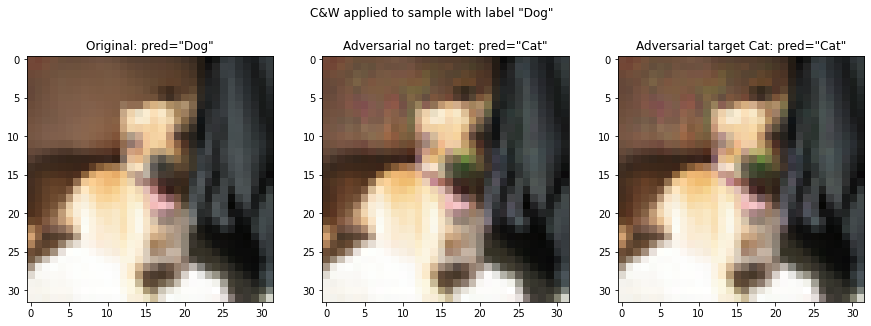

In [20]:
visualize_single_attack(baseline, ("C&W", CarliniWagnerAttack(device="cpu")))

Attack C&W: The baseline model has reached 0.00% of weighted accuracy.


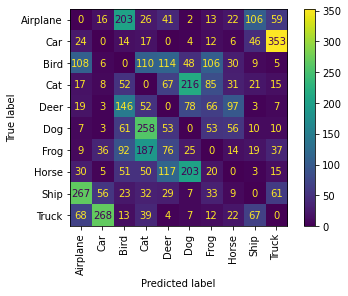

In [21]:
validate_adversarial(baseline, validationloader, ("C&W", CarliniWagnerAttack()))

In [22]:
gc.collect()
torch.cuda.empty_cache()

### 4. Kernel Density Estimation

#### 4.1 Kernel Density Estimator

This defense was proposed in ["Detecting Adversarial Samples from Artifacts"](https://arxiv.org/abs/1703.00410) by Feinman et al. Authors introduce a density estimate $\text{KDE}(x)$ that can be used as a measure how far $x$ is from submanifold of $t$. Specifically, given an instance $x$ classified as label $t$, the kernel density estimation is given by 



$$\text{KDE}(x) = \frac{1}{|X_t|} \sum_{x_i \in X_t} k_{\sigma}(  F^{n-1}(x_i) \text{, } F^{n-1}(x))$$
$$k_{\sigma}(x, y) \sim \text{exp}(-||x - y||^2 / \sigma^2)$$

where $k_\sigma(\cdot, \cdot)$ is the kernel function, $X_t$ is a set of training instances with label $t$, and $F^{n-1}(x)$ is the output of the final hidden layer on input $x$, and $\sigma$ is a bandwidth of a kernel that typically can be chosen as a value that maximizes the log-likelyhood of the training data. However, a value too small will give rise to a *spiky* density estimate with too many gaps, and a value too large will give rise to an overly-smooth density estimate. 

The methodology is taken directly from section 5.2 of ["Adversarial Examples Are Not Easily Detected: Bypassing Ten Detection Methods"](https://arxiv.org/abs/1705.07263) by Carlini N. and Wagner D. We will refer to it quite often in the following sections.

In [23]:
class KernelDensityEstimator:
    """Implementation of Kernel Density Estimator."""

    def __init__(self, model, sigma=20):
        """Constructor of kernel density estimator.

        Parameters
        ----------
        model : torch.Module
            image feature extractor from where there could
            be retrieved latent representation
        
        sigma : int
            bandwidth of a kernel
        """
        self.model = model
        self.sigma = sigma
        self.density_estimations = None
    
    def fit(self, trainset, labels, frac=0.002):
        """Estimate kernel density for the input data.

        Iteratively retrieves random sample from dataset, applies image feature
        extractor to it, and saves latent representation in dictionary by key 
        label. Assert that all classes indeed have desired number of data points.

        Important Note! - in original paper authors suggest to use a sample from 
        original dataset to perform kde. In fact, this sample might be imbalanced 
        in terms of image classes. Therefore, I've implemented slightly different 
        approach when user explicitly specifies required number of centers in each 
        class. 

        Parameters
        ----------
        trainset : torch.data.util.Dataset
            dataset containing images and class labels
        
        labels : iterable
            set of possible labels of images
        
        frac : float 
            should be in range of [0..1]
            minimal required portion of samples (centers) of each
            class to estimate density function
        """
        device = configs["device"]
        n_centers = int(len(trainset) * frac)
        self.n_centers = n_centers
        _density_estimations = {label: list() for label in labels}
        _finished = [False for _ in labels]
        with torch.no_grad():
            self.model.to(device)
            for idx in range(len(trainset)):
                image, label = trainset[idx]
                if len(_density_estimations[label]) >= n_centers:
                    _finished[label] = True
                    if all(_finished):
                        break
                    continue
                image = (image.to(device) / 255.0).unsqueeze(dim=0)
                _ = self.model(image)
                latent_representation = self.model.latent_representation.squeeze(0)
                _density_estimations[label].append(latent_representation)
                del image
            for label in labels:
                _density_estimations[label] = torch.stack(_density_estimations[label]) 
            message = "Provided dataset does not have desired number of centers for KDE!"
            assert all(_finished), message
            self.density_estimations = _density_estimations
        
    def get_epsilon(self):
        """Find epsilon for KDE loss of adversarial attack.

        As suggested in the paper as an epsilon in KDE loss there is used medean 
        of -log(KDE(x)) on the training set. This ensures that new loss is less or 
        equal zero iff KDE(x') is greater than half of the training instances KDE.

        Returns
        -------
        epsilon : float
            median of all KDEs on training instances
        """
        log_kdes = list()
        n_centers = self.n_centers
        for key in self.density_estimations.keys():
            _density_estimations = self.density_estimations[key]
            for idx in range(n_centers):
                x_representations = torch.stack([_density_estimations[idx]] * n_centers)
                kde = torch.mean(self._gaussian_kernel(_density_estimations, x_representations))
                log_kdes.append(-torch.log(kde))
        log_kdes = torch.FloatTensor(log_kdes)
        epsilon = torch.median(log_kdes).item()
        return epsilon

    def __call__(self, x):
        """Compute kernel density estimation for sample.

        This method is designed for batches, i.e. requires 4D arrays
        as an input. For a given batch predicts classes, then retrieves
        latent representations of training samples with same target, and
        finally computes KDE of input sample w.r.t. training data points.

        Parameters
        ----------
        x : torch.Tensor
            batch of images which KDE to be computed
        
        Returns
        -------
        kde : torch.Tensor
            1D array of KDEs for each input sample
        """
        if self.density_estimations is None:
            print("You should fit kernel density estimator first!")
            return 
        device = configs["device"]
        logits = self.model(x)
        _, predicted_classes = logits.max(dim=1)
        predicted_classes = list(predicted_classes.cpu().detach().numpy())
        batch_density_estimation = list()
        for predicted_class in predicted_classes:
            density_estimation = self.density_estimations[predicted_class]
            batch_density_estimation.append(density_estimation)
        batch_density_estimation = torch.stack(batch_density_estimation)
        batch_size, _, _ = batch_density_estimation.shape
        batch_x_representations = list()
        for idx in range(batch_size):
            x_representation = self.model.latent_representation[idx]
            batch_x_representation = torch.stack([x_representation] * self.n_centers)
            batch_x_representations.append(batch_x_representation)
        batch_x_representations = torch.stack(batch_x_representations)
        kde = torch.mean(self._gaussian_kernel(batch_density_estimation, batch_x_representations), dim=1)
        return kde
    
    def _gaussian_kernel(self, x, y):
        """Compute Gaussian Kernel.

        Implementation of Gaussian kernel function defined as 
            k(x, y) = exp(-norm(x - y)^2 / sigma^2)
        Works both for 1D and 2D data points.

        Parameters
        ----------
        x : torch.Tensor
            first data point(s)

        y : torch.Tensor
            second data point(s)
        
        Returns
        -------
        kernel : torch.Tensor
            Gaussian kernel
        """
        diff = x - y
        n_dim = len(diff.shape)
        norm = torch.norm(diff, dim=n_dim - 1) 
        kernel = torch.exp(-(norm / self.sigma) ** 2)
        return kernel

In [24]:
kde = KernelDensityEstimator(baseline)
kde.fit(trainset, list(classes.keys()), frac=0.02)

In [25]:
def compare_kde_distributions(kde, attack, model, validationloader):
    """Compare KDE distributions for natural and adversarial samples.

    KDE : KernelDensityEstimator
        kernel density estimator

    attack : CarliniWagnerAttack
        callable creating adversarial sample
    
    model : torch.Module
        model to attack
    
    validationloader : torch.data.utils.Dataloader
        iterable with validation data
    """
    naturals, adversarials = list(), list()
    device = configs["device"]
    for images, labels in validationloader:
        images, labels = images.to(device) / 255., labels.to(device)
        label = random.choice(list(classes.keys()))
        targets = torch.full(labels.shape, label)
        adversarial = attack(model, images, labels, targets)
        naturals.append(kde(images).detach())
        adversarials.append(kde(adversarial).detach())
    naturals  = torch.cat(naturals, dim=0).cpu().numpy()
    adversarials = torch.cat(adversarials, dim=0).cpu().numpy()

    print(f"Natural: {naturals.mean():.4f} ± {naturals.std():.4f}")
    print(f"Adversarial: {adversarials.mean():.4f} ± {adversarials.std():.4f}")
    print()

    pvalue = ttest_ind(naturals, adversarials).pvalue
    print("Null hypothesis: natural and adversarial samples come from same distribution ")
    print("Alternative hypothesis: adversarial samples come from different distribution")
    print("Confidende interval: 0.95")
    print(f"P-value: {pvalue:.4f}")
    print(f"T-test: {'Reject Null Hypothesis' if pvalue < 0.05 else 'Accept Null Hypothesis'}")

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(12, 8)
    ax.set_title("KDE distributions")
    ax.grid()
    ax.hist(naturals, bins=100, color='b', label="Natural")
    ax.hist(adversarials, bins=100, color='r', alpha=0.8, label="Adversarial")
    ax.legend()
    plt.show()

Natural: 0.3309 ± 0.0849
Adversarial: 0.2888 ± 0.0782

Null hypothesis: natural and adversarial samples come from same distribution 
Alternative hypothesis: adversarial samples come from different distribution
Confidende interval: 0.95
P-value: 0.0000
T-test: Reject Null Hypothesis


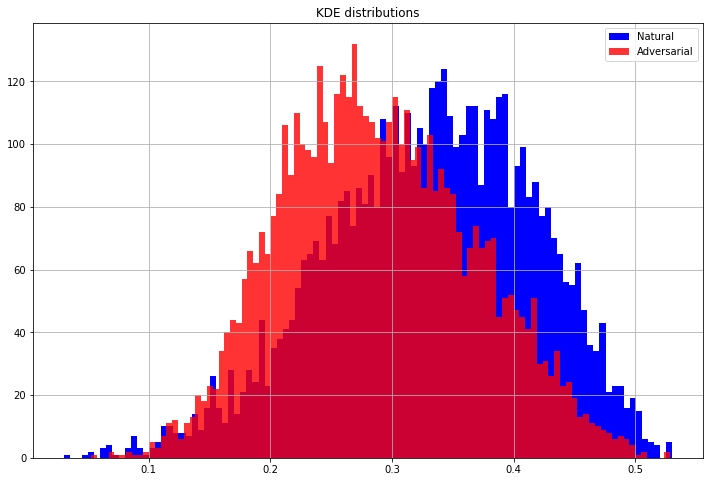

In [26]:
attack = CarliniWagnerAttack()
compare_kde_distributions(kde, attack, baseline, validationloader)

As you can see, there is a huge overlap between these two distributions. Firstly, we need to be sure that these two populations come from different distributions. Accordinly, let's introduce Null Hypothesis $N_0$: natural and adversarial samples come from same distribution, and Alternative Hypothesis: adversarial samples come from different distribution. Let's use Student's t-test with confidence interval of $0.95$: the $\text{p-value}$ is negligibly small, so we reject the Null Hypothesis.

Further, let's try to quantify these two populations: mean of KDEs for natural samples $\mu_n = 0.3309$ is located to the right of the adversarial mean $\mu_a = 0.2888$, the values of standard deviation are compatible for both cases $\sigma_n=0.0849 \sim 0.0782 = \sigma_a$. Therefore, we can say that natural samples are likely to have higher kernel density estimations than adversarial ones.

#### 4.2 Adversarial Detector

The detector over Kernel Density Estimator is thus constructed by selecting threshold $\tau$ and reporting $x$ as adversarial if $\text{KDE}(x) < \tau$, otherwise reporting $x$ is natural. Unfortunately, neither Carlini & Wagner or Feinman et al. provide algorithm to estimate this threshold. Therefore, I propose quite natural (or even naive) way to define $\tau$.

Assuming that defender has both train and test subsets to construct adversarial detector, let's estimate kernel density for each sample in test dataset. The result will be an array of KDEs, for which we further compute mean $\mu$ and standard deviation $\sigma$. Threshold $\tau$ thus is given by
$$\tau = \mu - c \cdot \sigma$$
where $c$ is coefficient representing our confidence in estimate, emperically* I found that $\tau = 0.05$ is sufficient for CIFAR dataset 

\* grid search with step size of $0.05$ on 100 random shuffles of dataset

In [27]:
class DetectorKDE:
    """Implementation of KDE-based adversarial detector."""

    def __init__(self, kde, tau):
        """Constructor of KDE-based adversarial detector.

        Parameters
        ----------
        kde : KernelDensityEstimator
            kernel density esttimator
        
        tau : float
            threshold of kernel denstiy estimation to classify 
            as natural, i.e. if KDE(x) > tau then sample is natural
            and adversarial otherwise
        """
        self.kde = kde
        self.tau = tau
    
    def __call__(self, x):
        """Detect adversarial samples.

        Parameters
        ----------
        x : torch.Tensor
            4D array of images 

        Returns
        -------
        mask : torch.Tensor
            classes of samples: 0 if natural, 1 if adversarial
        """
        kde = self.kde(x)
        mask = (kde < self.tau).long()
        return mask

In [28]:
def estimate_tau(kde, testloader, c=0.05):
    """Estimate tau for KDE-based adversarial detector.

    Intended to be estimated on test dataset. Determines mean 
    and standard deviaton of KDEs over test samples. Threshold
    tau is computed as mean - std.

    Parameters
    ----------
    kde : KernelDensityEstimator
        kernel density esttimator
    
    testloader : torch.data.utils.Dataloader
        iterable with test data
    
    Returns
    -------
    tau : float
        threshold for adversarial samples detection
    """
    with torch.no_grad():
        kdes = list()
        device = configs["device"]
        for images, labels in testloader:
            images, labels = images.to(device) / 255., labels.to(device)
            kdes.append(kde(images)) 
        kdes = torch.cat(kdes, dim=0)
        tau = (kdes.mean() - c * kdes.std()).item()
        return tau

In [29]:
def validate_detector(detector, attack, model, validationloader):
    """Validate KDE-based detector.

    Computes accuracy of detector on joint dataset of natural and 
    adversarial samples.

    Parameters
    ----------
    detector : DetectorKDE
        detector of adversarial samples

    attack : CarliniWagnerAttack
        callable creating adversarial sample
    
    model : torch.Module
        model to attack
    
    validationloader : torch.data.utils.Dataloader
        iterable with validation data
    """
    hits = 0
    device = configs["device"]
    for images, labels in validationloader:
        images, labels = images.to(device) / 255., labels.to(device)
        n_samples = images.shape[0]
        label = random.choice(list(classes.keys()))
        targets = torch.full(labels.shape, label)
        adversarial = attack(model, images, labels, targets)
        hits += n_samples - detector(images).sum().item() + detector(adversarial).sum().item()
    print(f"Accuracy of detector: {0.5 * hits / len(validationloader.dataset) * 100:.2f}%")

In [30]:
tau = estimate_tau(kde, testloader)
print(f"Tau: {tau:.4f}")

Tau: 0.3270


In [31]:
detector = DetectorKDE(kde, tau)

#### 4.3 Zero-Knowledge Attack Evaluation

In [32]:
def evaluate_kde(kde, attack, model, validationloader):
    """Consider KDE behaviour for natural and adversarial samples.

    Parameters
    ----------
    kde : KernelDensityEstimator
        kernel density estimator

    attack : CarliniWagnerAttack
        callable creating adversarial sample
    
    model : torch.Module
        model to attack
    
    validationloader : torch.data.utils.Dataloader
        iterable with validation data
    """
    naturals, adversarials = list(), list()
    device = configs["device"]
    for images, labels in validationloader:
        images, labels = images.to(device) / 255., labels.to(device)
        label = random.choice(list(classes.keys()))
        targets = torch.full(labels.shape, label)
        adversarial = attack(model, images, labels, targets)
        naturals.append(kde(images).detach())
        adversarials.append(kde(adversarial).detach())
    naturals  = torch.cat(naturals, dim=0).cpu().numpy()
    adversarials = torch.cat(adversarials, dim=0).cpu().numpy()
    difference = adversarials - naturals
    false_positives = (difference > 0).sum()

    print("Difference = Adversarial — Original")
    print(f"Mean ± STD: {difference.mean():.4f} ± {difference.std():.4f}")
    print(f"Skewness: {skew(difference):.4f}")
    print(f"Pair-wise false positives: {false_positives / len(validationloader.dataset) * 100:.2f}%")

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(12, 8)
    ax.set_title("Difference")
    ax.grid()
    ax.axvline(color='k', linestyle='--')
    ax.hist(difference, bins=100, color='r')
    plt.show()

In [33]:
attack = CarliniWagnerAttack()

In [34]:
validate_detector(detector, attack, baseline, validationloader)

Accuracy of detector: 63.83%


You might wonder, why even after selection of $\tau$ the performance is poor (~60%)? The answer is that the defense does not work in general case. As we saw earlier distributions of KDEs intersect noticeably. This complicates the process of detecting adversarial examples. Carlini and Wagner claim that for simpler datasets such as MNIST, Feinman's defense is able to detect C&W adversarial examples, but for CIFAR it fails.

You also might ask, why did I chose this defense then? If authors argue that it does not work on CIFAR, then usage of this defense is pointless. My reply is as follows (a) this defense is the most interesting in terms of implementation for me and (b) although authors of paper are smart guys I would refer to [The Problem of Expertise](https://link.springer.com/article/10.1007/s11024-016-9308-7) and try to replicate their findings.

Now, let's follow methodology proposed in paper and check how KDE behave on the test set. For each image in the test set $x$ and closest adversarial example $x'$, compare $\text{KDE}(x)'$ and $\text{KDE}(x')$.

Difference = Adversarial — Original
Mean ± STD: -0.0488 ± 0.1004
Skewness: 0.0635
Pair-wise false positives: 31.46%


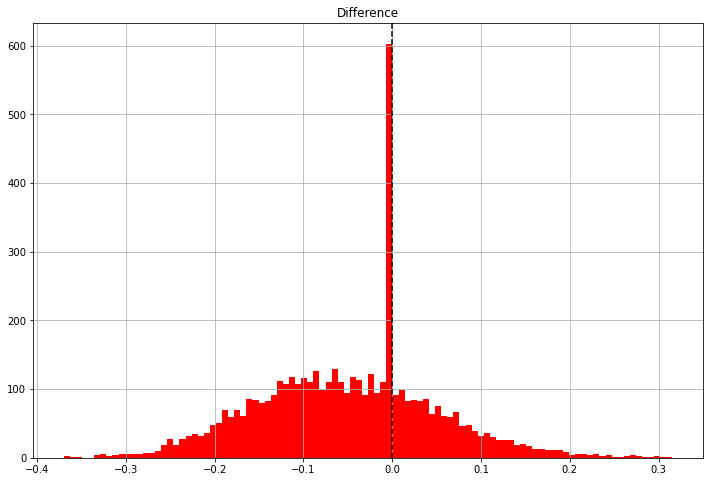

In [35]:
attack = CarliniWagnerAttack()
evaluate_kde(kde, attack, baseline, validationloader)

Although authors declare that 80% of the time the adversarial example has a higher likelyhood score that original image, I've encountered this behaviour only in $31.46$% of cases. Perhaps, this caused by difference in model architecture, KDE parameters, and stochasticity of the process.

#### 4.4 Perfect-Knowledge Attack Evaluation

Now assume that we know everything about the defence and try to perform white-box attack. Carlini & Wagner propose a new minimization formulation with a novel loss term $l_2(x')$ that penalizes being detected by detector.
$$\text{minimize} ||x - x'||^2_2 + c \cdot (l(x')+l_2(x'))$$
$$l_2(x') = \text{max}(-\text{log}(\text{KDE}(x'))-\epsilon, 0)$$
where $\epsilon$ controls the likelyhood measure of the adversarial samples. Following suggestions in manuscript I set $\epsilon$ to the median of $- \log(\text{KDE}(\cdot))$ on the training set, so that $l_2(x') \leq 0$ if and only if $\text{KDE}(x')$ is greater than half of the training instances KDE. Recall that class `KernelDensityEstimator` has method `get_epsilon`. 

Whereas authors perform two-step optimization, I think it is unjustified. The main argument of Carlini & Wagner is that this approach allows to use different constants to generate an adversarial example and to "fine-tune" it to not be detected. Instead, I introduce a new constant $c_2$ that is used to regulate directly KDE loss term. Intuitively, it ensures more stable adversarial attacking.
$$\text{minimize} ||x - x'||^2_2 + c \cdot l(x')+ c_2 \cdot l_2(x')$$

In [36]:
class CarliniWagnerAttackKDE(CarliniWagnerAttack):
    """Implementation of Carlini & Wagner attack with KDE loss."""

    def __init__(self, kde, c1=10, c2=20, lr=1e-2, iterations=10, device="cuda"):
        """Constructor of C&W attack with KDE loss.

        Parameters
        ----------
        kde : KernelDensityEstimator
            kernel density estimator

        c1 : int
            coefficient on which loss function f6 is multiplied
        
        c2 : int
            coefficient on which kde loss function is multiplied
        
        lr : float
            learning rate of an attack
        
        iterations : int
            number of iterations of an attack
        
        device : str
            device to use for computations
        """
        super().__init__(c=c1, lr=lr, iterations=iterations, device=device)
        self.c2 = c2
        self.kde = kde
        self.eps = kde.get_epsilon()
    
    def _attack(self, model, x, y, target):
        """Implementation of attacking.

        Adversarial sample is the result of optimization with an objective 
        function comprised of L2-norm, rectifier function f6 and KDE loss as 
        suggested in original paper. Note that resultant adversarial sample is 
        in the range of [0..1].

        Parameters
        ----------
        model : torch.Module

        x : torch.Tensor
            images of an input batch

        y : torch.Tensor
            class labels of an input batch

        target : torch.Tensor
            target class labels for the attack
        
        Returns
        -------
        adversarial_sample : torch.Tensor
            resultant adversarial sample
        """
        w = torch.atanh(2 * x - 1).to(self.device)
        w.requires_grad = True
        optimizer = optim.SGD([w], lr=self.lr)
        for _ in range(self.iterations):
            optimizer.zero_grad()
            adversarial_sample = 0.5 * (torch.tanh(w) + 1)
            l2_norm = nn.MSELoss()(adversarial_sample, x)     
            kde_loss = self._kde_loss(adversarial_sample).sum()
            f6 = self._f6(model, adversarial_sample, y, target).sum()
            objective = self.c * f6 + self.c2 * kde_loss
            loss = l2_norm + objective
            loss.backward()
            optimizer.step()
        return adversarial_sample.detach()
    
    def _kde_loss(self, x):
        """KDE loss implementation."""
        kde_log = -torch.log(self.kde(x)) - self.eps
        kde_loss = nn.ReLU()(kde_log)
        return kde_loss

Difference = Adversarial — Original
Mean ± STD: 0.0531 ± 0.0892
Skewness: 0.2388
Pair-wise false positives: 70.34%


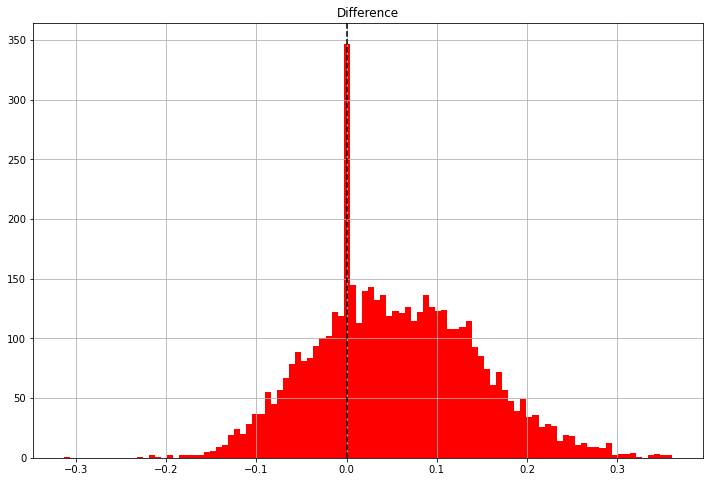

In [37]:
attack = CarliniWagnerAttackKDE(kde)
evaluate_kde(kde, attack, baseline, validationloader)

Wow! I just managed to increase a number of samples $x$ for which KDE of closest adversarial example $x'$ has a higher likelyhood score from $31.46$% to $70.34$%. Also, notice how distribution has changed: its mean gets to the right, skewness increased, number of samples with nearly zero difference decreased. Thus, the modified attack works as intended.

In [38]:
gc.collect()
torch.cuda.empty_cache()

#### 4.5 Limited-Knowledge Attack Evaluation

Further Carlini & Wagner consider the case when the defender uses the first 95% of the training data, and the last 5% of the training data is left for the adversary (who uses it to form their own KDE estimator). Let's try to replicate this scenario.

In [39]:
defender_size = int(0.95 * len(trainset))
adversary_size = len(trainset) - defender_size
defender_set, adversary_set = torch.utils.data.random_split(trainset, [defender_size, adversary_size], generator=torch.Generator().manual_seed(42))
defenderloader = DataLoader(defender_set, batch_size=configs['batch_size'], shuffle=True, num_workers=configs['num_workers'])
adversaryloader = DataLoader(adversary_set, batch_size=configs['batch_size'], shuffle=True, num_workers=configs['num_workers'])

In [40]:
print(f"Defender dataset: {len(defenderloader.dataset)} that is {len(defenderloader.dataset) / len(trainset) * 100}% of trainset")
print(f"Adversary dataset: {len(adversaryloader.dataset)} that is {len(adversaryloader.dataset) / len(trainset) * 100}% of trainset")

Defender dataset: 47500 that is 95.0% of trainset
Adversary dataset: 2500 that is 5.0% of trainset


In [41]:
kde = KernelDensityEstimator(baseline)
kde.fit(defender_set, list(classes.keys()), frac=0.02)
actual_defence = DetectorKDE(kde, tau)

In [42]:
kde_adversary = KernelDensityEstimator(baseline)
kde_adversary.fit(adversary_set, list(classes.keys()), frac=0.02)
adversary_defence = DetectorKDE(kde_adversary, tau)

In [43]:
attack_baseline = CarliniWagnerAttack()
attack_kde = CarliniWagnerAttackKDE(kde_adversary)

##### 4.5.1 Benchmark attack

In [44]:
validate_detector(actual_defence, attack_baseline, baseline, validationloader)

Accuracy of detector: 61.55%


Difference = Adversarial — Original
Mean ± STD: -0.0451 ± 0.1003
Skewness: 0.0717
Pair-wise false positives: 32.62%


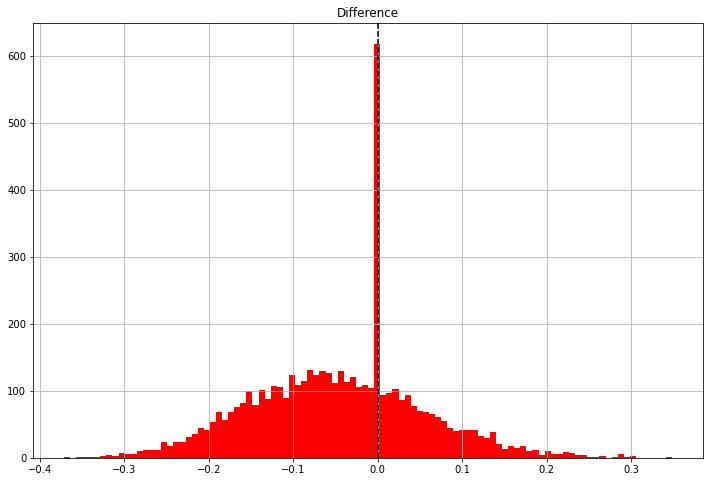

In [45]:
evaluate_kde(kde, attack_baseline, baseline, validationloader)

##### 4.5.2 Attack using 5% of training data

In [46]:
validate_detector(actual_defence, attack_kde, baseline, validationloader)

Accuracy of detector: 29.20%


Difference = Adversarial — Original
Mean ± STD: 0.0546 ± 0.0953
Skewness: 0.1259
Pair-wise false positives: 70.46%


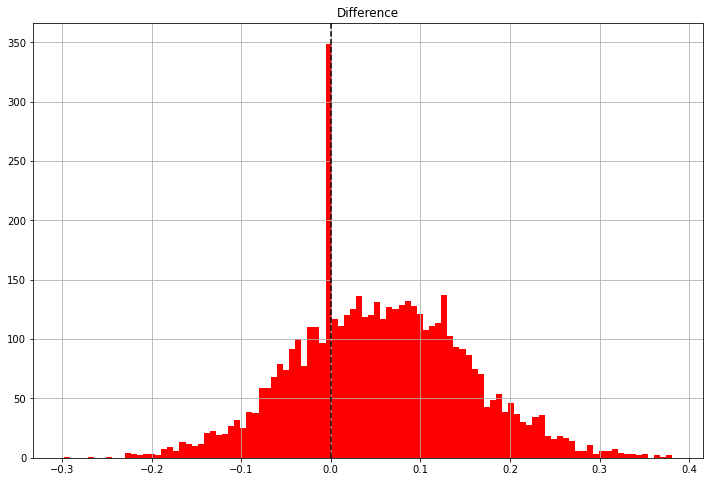

In [47]:
evaluate_kde(kde_adversary, attack_kde, baseline, validationloader)

We observe the same phenomena as with the perfect-knowledge attack: accuracy of detector has droped from $61.55$% to $29.20$%, number of cases when KDE for adversary is greater than for natural is increased from $32.62$% to $70.46$%, and the mean of difference moved to the right. However, now there was used $<5$% of training data to construct an attack. This once again convinces us of the weakness of the Kernel Density Estimation defense and the strength of the C&W attack.

### Discussion

This notebook concludes our experiments on the topic of adversarial attacking and defending. As a part of this work there was implemented statistical defense called Kernel Density Estimation. It was tested against C&W attack and C&W attack with KDE loss, which decreased the peformance of Kernel Density Estimation detector. The obtained results match the results proposed by Carlini and Wagner in ["Adversarial Examples Are Not Easily Detected: Bypassing Ten Detection Methods"](https://arxiv.org/abs/1705.07263). 